# **HOUSE PRICE PREDICTION**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/DATASETS/data.csv')
df.info()
df.shape

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4600 entries, 0 to 4599
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           4600 non-null   object 
 1   price          4600 non-null   float64
 2   bedrooms       4600 non-null   float64
 3   bathrooms      4600 non-null   float64
 4   sqft_living    4600 non-null   int64  
 5   sqft_lot       4600 non-null   int64  
 6   floors         4600 non-null   float64
 7   waterfront     4600 non-null   int64  
 8   view           4600 non-null   int64  
 9   condition      4600 non-null   int64  
 10  sqft_above     4600 non-null   int64  
 11  sqft_basement  4600 non-null   int64  
 12  yr_built       4600 non-null   int64  
 13  yr_renovated   4600 non-null   int64  
 14  street         4600 non-null   object 
 15  city       

(4600, 18)

In [4]:
print(f"Dataset shape: {df.shape}")
print(df.describe())

X = df.drop('price', axis=1)
y = df['price']

Dataset shape: (4600, 18)
              price     bedrooms    bathrooms   sqft_living      sqft_lot  \
count  4.600000e+03  4600.000000  4600.000000   4600.000000  4.600000e+03   
mean   5.519630e+05     3.400870     2.160815   2139.346957  1.485252e+04   
std    5.638347e+05     0.908848     0.783781    963.206916  3.588444e+04   
min    0.000000e+00     0.000000     0.000000    370.000000  6.380000e+02   
25%    3.228750e+05     3.000000     1.750000   1460.000000  5.000750e+03   
50%    4.609435e+05     3.000000     2.250000   1980.000000  7.683000e+03   
75%    6.549625e+05     4.000000     2.500000   2620.000000  1.100125e+04   
max    2.659000e+07     9.000000     8.000000  13540.000000  1.074218e+06   

            floors   waterfront         view    condition   sqft_above  \
count  4600.000000  4600.000000  4600.000000  4600.000000  4600.000000   
mean      1.512065     0.007174     0.240652     3.451739  1827.265435   
std       0.538288     0.084404     0.778405     0.677230 

In [5]:
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

missing_threshold = 0.5
missing_cols = df.columns[df.isnull().mean() > missing_threshold]
X = X.drop(columns=missing_cols)

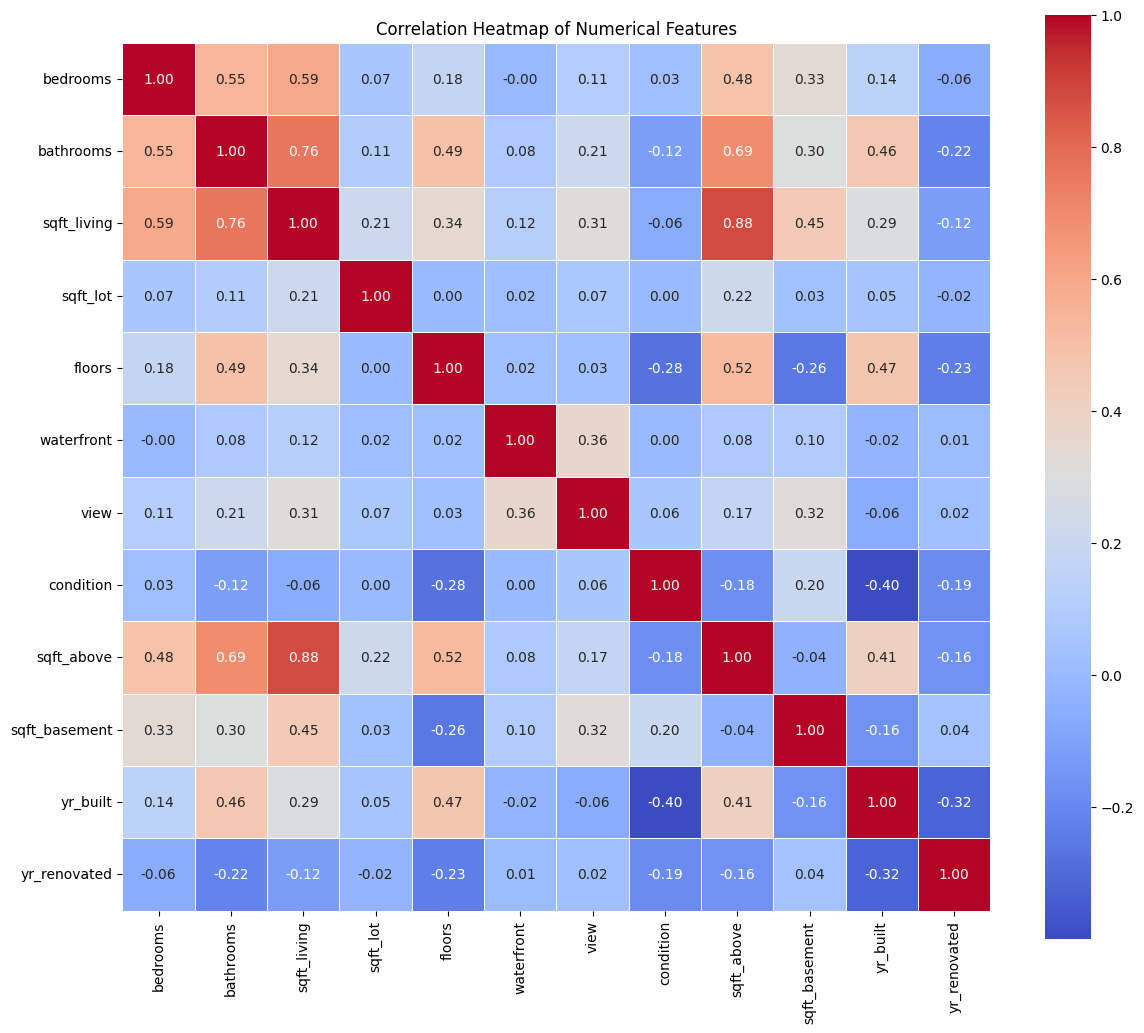

In [19]:
numeric_cols_only = X.select_dtypes(include=['int64', 'float64'])
corr_matrix = numeric_cols_only.corr()
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_features = [column for column in upper_triangle.columns if any(upper_triangle[column].abs() > 0.90)]
X = X.drop(columns=high_corr_features)

numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar=True, linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

In [12]:
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False))
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

In [13]:
preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Model Pipeline
model_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', Ridge())
])

In [15]:
#Hyperparameter Tuning using GridSearchCV
param_grid = {
    'regressor__alpha': [0.1, 1.0, 10.0, 50.0, 100.0],
}

grid_search = GridSearchCV(model_pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print("\nBest Hyperparameters:", grid_search.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Hyperparameters: {'regressor__alpha': 10.0}


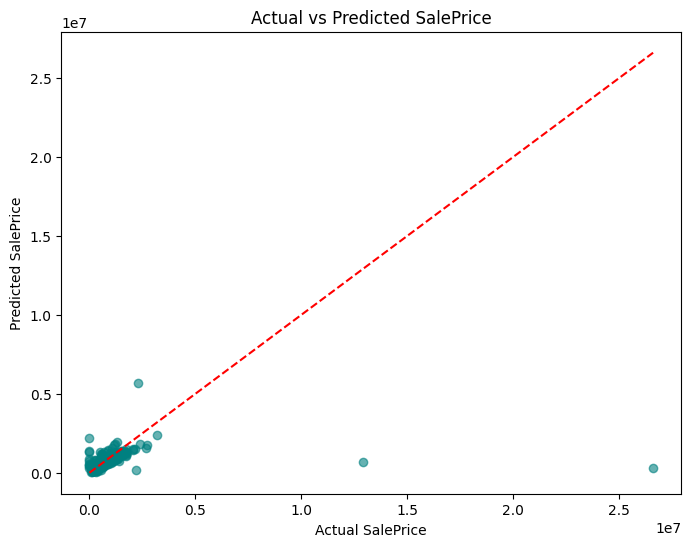

In [24]:
y_pred = best_model.predict(X_test)

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.6, color='teal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel('Actual SalePrice')
plt.ylabel('Predicted SalePrice')
plt.title('Actual vs Predicted SalePrice')
plt.show()

In [23]:
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"\nFinal Model Performance:")
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


Final Model Performance:
R² Score: 0.0501
Mean Absolute Error (MAE): 157176.55
Root Mean Squared Error (RMSE): 984242.58


In [26]:
cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='r2')
print(f"\nCross Validation R² Mean Score: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")


Cross Validation R² Mean Score: 0.4524 (+/- 0.2725)


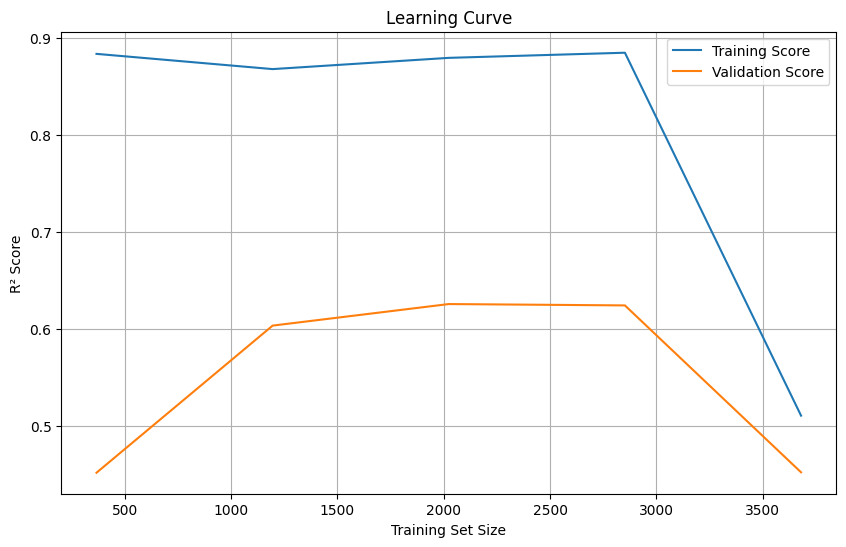

In [18]:
train_sizes, train_scores, test_scores = learning_curve(best_model, X, y, cv=5, scoring='r2', n_jobs=-1)
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_mean, label='Training Score')
plt.plot(train_sizes, test_mean, label='Validation Score')
plt.xlabel('Training Set Size')
plt.ylabel('R² Score')
plt.title('Learning Curve')
plt.legend()
plt.grid()
plt.show()

In [21]:
joblib.dump(best_model, 'house_price_model.pkl')
print("\nModel saved as 'house_price_model.pkl'")


Model saved as 'house_price_model.pkl'


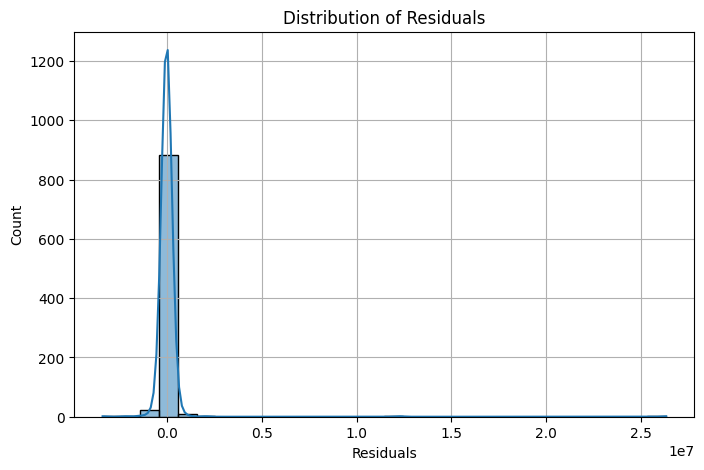

In [22]:
#Residuals Analysis
residuals = y_test - y_pred
plt.figure(figsize=(8,5))
sns.histplot(residuals, kde=True, bins=30)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.grid()
plt.show()

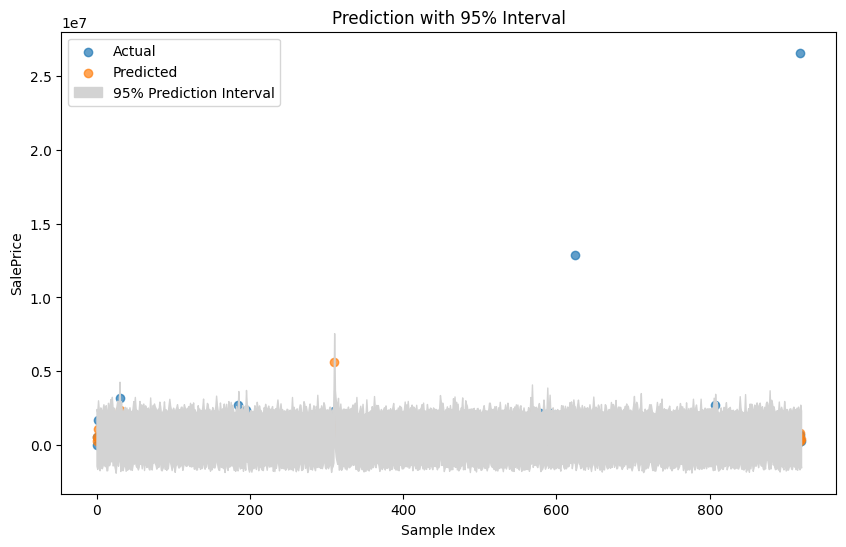

In [25]:
residuals = y_test - y_pred
std_dev = np.std(residuals)

lower_bound = y_pred - 1.96 * std_dev
upper_bound = y_pred + 1.96 * std_dev

plt.figure(figsize=(10,6))
plt.scatter(range(len(y_test)), y_test, label='Actual', alpha=0.7)
plt.scatter(range(len(y_pred)), y_pred, label='Predicted', alpha=0.7)
plt.fill_between(range(len(y_pred)), lower_bound, upper_bound, color='lightgrey', label='95% Prediction Interval')
plt.legend()
plt.title('Prediction with 95% Interval')
plt.xlabel('Sample Index')
plt.ylabel('SalePrice')
plt.show()